<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/main/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
# System Imports
from os import remove
import string

# Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomAffine, RandomPerspective
from torchvision.transforms.functional import normalize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataloading and saving
import pickle as pkl
import pandas as pd

# Numpy
import numpy as np

# Logging and Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Mount Google Drive To Access Data and Store Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Data

In [3]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
    validation_size = training_data.shape[0]//10
    validation_data = training_data[0:validation_size]
    training_data = training_data[validation_size:]
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
    validation_size = training_labels.shape[0]//10
    validation_labels = training_labels[0:validation_size]
    training_labels = training_labels[validation_size:]
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)
with open("/content/drive/My Drive/data/images_ul.pkl", 'rb') as f: 
    unlabeled_data = pkl.load(f)

## Preprocessing

### Preprocessing Helper Functions

In [4]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1, l2 = int(label[0]), mapping[label[1].int()]
    readables.append((l1,l2,))
  return readables

In [5]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])    
    # plt.colorbar()
    plt.show()

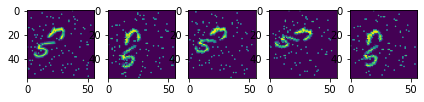

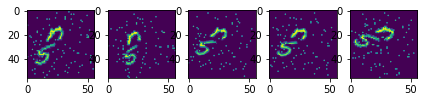

In [6]:
affine_manager = RandomAffine(30, scale=(0.9,1.1), shear=10)
def generate_affine(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(affine_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[989,None]).float()
affined_tensors = map(lambda x: x[0], generate_affine(sample_tensor,9))
img_grid(2,5,[sample_tensor[0],*affined_tensors])

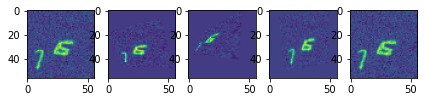

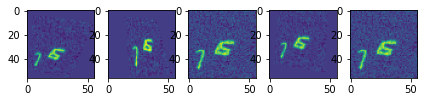

In [7]:
perspective_manager = RandomPerspective(0.7)
def generate_pespective(image_tensor, num):
    outputs = []
    for _ in range(num):
      outputs.append(perspective_manager(image_tensor))
    return outputs

sample_tensor = torch.from_numpy(training_data[999,None]).float()
perspective_tensors = map(lambda x: x[0], generate_pespective(sample_tensor,9))
img_grid(2,5,[sample_tensor[0],*perspective_tensors])

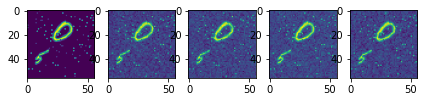

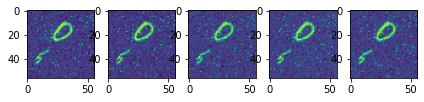

In [8]:
def generate_noise(image_tensor, num, std = 0.4):
  outputs = []
  for i in range(num):
    outputs.append(image_tensor + (torch.randn(image_tensor.size()) * std))
  return outputs

sample_tensor = torch.from_numpy(training_data[10000,None]).float()
norm_img = torch.clip(sample_tensor,0,255)
mean, std = torch.mean(norm_img), torch.std(norm_img)
norm_img = normalize(norm_img, [mean], [std])
noisy_tensors = map(lambda x: x[0], generate_noise(norm_img,9))
img_grid(2,5,[sample_tensor[0],*noisy_tensors])

In [9]:
# transform all data to the output format
def process_training_data(data, labels, affine_cnt = 0, perspective_cnt = 0, noise_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt+noise_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,0:10]))
    letter_labels[i*multiplier:(i+1)*multiplier] = int(np.argmax(labels[i,10:]))
    # Creating the rotation and sharpness images
    norm_img = torch.clip(data_tensor[i],0,255)
    mean, std = torch.mean(norm_img), torch.std(norm_img)
    norm_img = normalize(norm_img, [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
    for n_img in generate_noise(norm_img, noise_cnt):
      new_data[output_index] = n_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset

In [10]:
def make_data_loader(dataset, batch_size=30, shuffle=True, num_workers=2):
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
  return dataloader

In [11]:
def process_testing_data(data):
  data_tensor = torch.from_numpy(data[:,None]).float()
  dataset = torch.empty((len(data),1,56,56))
  for i in tqdm(range(len(data_tensor))):
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = normalize(data_tensor[i], [mean], [std])
    dataset[i] = norm_img
  return dataset


In [12]:
# transform all data to the output format
def process_unlabeled_data(data, labels, affine_cnt = 0, perspective_cnt = 0, noise_cnt = 0):
  multiplier = (1+affine_cnt+perspective_cnt)
  data_tensor = torch.from_numpy(data[:,None]).float()
  new_data = torch.empty((len(data)*multiplier,1,56,56))
  num_labels = torch.empty(len(data)*multiplier)
  letter_labels = torch.empty(len(data)*multiplier)
  output_index = 0
  for i in tqdm(range(len(data_tensor))):
    # Assign the labels to the new data
    num_labels[i*multiplier:(i+1)*multiplier] = labels[i,0]
    letter_labels[i*multiplier:(i+1)*multiplier] = labels[i,1]
    # Creating the rotation and sharpness images
    mean, std = torch.mean(data_tensor[i]), torch.std(data_tensor[i])
    norm_img = normalize(data_tensor[i], [mean], [std])
    new_data[output_index] = norm_img; output_index+=1
    for r_img in generate_affine(norm_img, affine_cnt):
      new_data[output_index] = r_img; output_index+=1
    for s_img in generate_pespective(norm_img, perspective_cnt):
      new_data[output_index] = s_img; output_index+=1
    for n_img in generate_noise(norm_img, noise_cnt):
      new_data[output_index] = n_img; output_index+=1
  
  # Creating the datasets
  multi_label_tensor = torch.stack((num_labels,letter_labels), axis=1).long()
  dataset = TensorDataset(new_data, multi_label_tensor)
  return dataset

### Processing The Data

Process the data and put the data into dataloader

In [13]:
print("Processing Training Data")
training_dataset = process_training_data(training_data, training_labels, 2, 2, 1)

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import h5py
 
class dataset_h5(torch.utils.data.Dataset):
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()
 
        self.file = h5py.File(in_file, 'r')
        self.transform = transform
 
    def __getitem__(self, index):
        x = self.file['X_train'][index, ...]
        y = self.file['Y_train'][index, ...]
        
        # Preprocessing each image
        if self.transform is not None:
            x = self.transform(x)        
        
        return x, y
 
    def __len__(self):
        return self.file['X_train'].shape[0]
training_set, training_labels = training_dataset[:]
with h5py.File('data.h', "w") as out:
   out['X_train'] = training_set
   out['Y_train'] = training_labels
dataset = dataset_h5("data.h")
training_loader = DataLoader(
        dataset, batch_size=30, shuffle=True, num_workers=2)

Processing Training Data


  0%|          | 0/27000 [00:00<?, ?it/s]

In [14]:
print("Processing Validation Data")
validation_dataset = process_training_data(validation_data,validation_labels)
validation_loader = make_data_loader(validation_dataset)

Processing Validation Data


  0%|          | 0/3000 [00:00<?, ?it/s]

In [15]:
print("Processing Testing Data")
testing_dataset = process_testing_data(testing_data)

Processing Testing Data


  0%|          | 0/15000 [00:00<?, ?it/s]

Show training data samples for validation

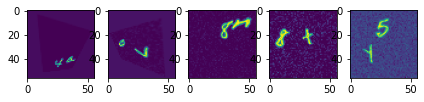

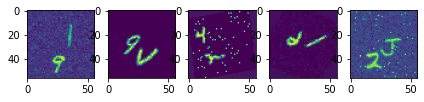

[(4, 'a'), (0, 'v'), (8, 'r'), (8, 't'), (5, 'y'), (9, 'i'), (9, 'v'), (4, 'r'), (1, 'd'), (2, 'j')]


In [16]:
def show_sample(n):
  perm = torch.randperm(len(training_dataset))
  idx = perm[:n]
  data, labels = training_dataset[idx]
  img_grid(n//5,5 , data[:,0])
  print(convert_labels_to_readables(labels))
show_sample(10)

## Training Model

Custom AlexNet

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 6, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 4, padding=1, stride=1)
        self.conv3 = nn.Conv2d(256, 256, 3, padding='same')
        self.conv4 = nn.Conv2d(256, 256, 3, padding='same')
        self.conv5 = nn.Conv2d(256, 128, 3, padding='same')
        # 3 Dense Layer
        self.fc11 = nn.Linear(3200, 2000)  
        self.fc21 = nn.Linear(3200, 2000)  
        self.fc12 = nn.Linear(2000, 1000)
        self.fc22 = nn.Linear(2000, 2000)
        self.fc13 = nn.Linear(1000, 10)
        self.fc23 = nn.Linear(2000, 1200)
        self.fc24 = nn.Linear(1200, 26)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 3)
        x = F.max_pool2d(F.relu(self.conv2(x)), 3)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        # print(x.size())
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        
        x1 = F.relu(self.fc11(x))
        x1 = F.relu(self.fc12(x1))
        l1 = self.fc13(x1)

        x2 = self.fc21(x)
        x2 = self.fc22(x2)
        x2 = self.fc23(x2)
        l2 = self.fc24(x2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Custom Res Net with Multi Output




Define the residual block module

In [18]:
class Block(nn.Module):
  def __init__(self, inplane, outplane, stride = 1):
    super(Block, self).__init__()
    self.inplane = inplane
    self.outplane = outplane
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(inplane, outplane, 3, padding=1, bias=False, stride=stride)
    self.bn1 = nn.BatchNorm2d(outplane)
    self.conv2 = nn.Conv2d(outplane, outplane, 3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(outplane)

    # If size change or stride, add a convolution layer to shortcut
    self.convi, self.bni = nn.Identity(), nn.Identity()
    if inplane != outplane or stride != 1: 
      self.convi = nn.Conv2d(inplane, outplane, 1, bias=False, stride=stride)
      self.bni = nn.BatchNorm2d(outplane)
  
  def forward(self, x):
        identity = self.bni(self.convi(x))
        # Two Convlution + Shortcut
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

Define the resnet model

In [19]:
class CustomResNet(nn.Module):
    # Used to save file and identify model configuration
    def get_layout(self):
      return f"CH-{self.channel_size}-C3-B[2,4,4,2]"

    def __init__(self, channel_size = 20):
        super(CustomResNet, self).__init__()
        self.channel_size = channel_size

        # One high level convolution layer
        self.top_layer = nn.Sequential(
            nn.Conv2d(1, channel_size, 3, padding=1, bias=False),
            nn.BatchNorm2d(channel_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        
        # 4 Residual layers of various block sizes
        self.res_layer1 = nn.Sequential(
            Block(channel_size, channel_size),
            Block(channel_size, channel_size)
        )
      
        self.res_layer2 = nn.Sequential(
            Block(channel_size, 2*channel_size, 2),
            Block(2*channel_size, 2*channel_size),
            Block(2*channel_size, 2*channel_size),
        )

        self.res_layer3 = nn.Sequential(
            Block(2*channel_size, 4*channel_size, 2),
            Block(4*channel_size, 4*channel_size),
            Block(4*channel_size, 4*channel_size),
            Block(4*channel_size, 4*channel_size),
        )
      
        self.res_layer4 = nn.Sequential(
            Block(4*channel_size, 8*channel_size, 2),
            Block(8*channel_size, 8*channel_size),
        )

        # Final Pooling and 1 dense layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dense_layers1 = nn.Linear(8*channel_size, 10)
        self.dense_layers2 = nn.Linear(8*channel_size, 26)

    def forward(self, x):
        x = self.top_layer(x)
        x = self.res_layer1(x)
        x = self.res_layer2(x)
        x = self.res_layer3(x)
        x = self.res_layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.dense_layers1(x), self.dense_layers2(x)

### Training and Validation

#### Training Helper Function

Initialize network validation and training function

In [20]:
multi_net_criterion = nn.CrossEntropyLoss()
def criterion(outputs, labels):
    o1, o2 = outputs
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2

In [21]:
best_loss, best_backup_filepath = 36.0, None
backup_folder = '/content/drive/My Drive/data/backup'

def backup_network(net, name = 'temp'):
  global backup_folder
  name = name.replace('.','_')
  network_file_path = f'{backup_folder}/{net.get_layout()}-{name}.pth'
  torch.save(net.state_dict(), network_file_path)
  print(f'Back up model to: {network_file_path}')
  return network_file_path

def backup_if_better_network(net, loss, accuracy):
  global best_loss, best_backup_filepath
  name = 'L{0:.8f}-P{1:.4f}'.format(loss, accuracy)
  if best_loss > loss:
    best_loss = loss
    network_file_path = backup_network(net,name)
    if best_backup_filepath is not None:
      remove(best_backup_filepath)
    best_backup_filepath = network_file_path

In [22]:
def validate_network(net, backup = True):
  digit_acc, letter_acc, total_loss = 0.0, 0.0, 0.0
  for i, validation_data in enumerate(tqdm(validation_loader, position=0, leave=False)):
    inputs, labels = validation_data
    outputs = net(inputs)
    total_loss += criterion(outputs, labels).item()
    o1, o2 = outputs
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float()).float()
  average_loss = total_loss / len(validation_loader)
  digit_acc = (digit_acc/len(validation_loader)).item()
  letter_acc = (letter_acc / len(validation_loader)).item()
  if backup:
    backup_if_better_network(net, average_loss, digit_acc*letter_acc)
  print(f'Val Loss: {average_loss}, Digit Acc: {digit_acc}, Letter Accuracy: {letter_acc}')

In [23]:
def backward(net, data, optimizer, criterion = criterion):
  inputs, labels = data
  optimizer.zero_grad()
  outputs = net(inputs)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  return loss.item()

In [24]:
def train_network(net, optimizer, scheduler, epoch_to_run = 1, iter_to_step = 100, iter_to_validate = 500, loader = training_loader):
  global best_backup_filepath, best_loss
  best_loss, best_backup_filepath = 36.0, None # reinitialize backup
  running_loss, cnt = 0.0, 0
  last_index = len(loader) * (epoch_to_run - int(epoch_to_run))
  epoch_to_run = int(epoch_to_run) + 1
  for epoch in range(epoch_to_run):
    for i, data in enumerate(tqdm(loader, leave=False)):
      if epoch == epoch_to_run - 1 and i > last_index:
        break
      running_loss += backward(net, data, optimizer)
      cnt+=1
      if i % iter_to_step == iter_to_step - 1:
        scheduler.step()
        print('[{0}:{1}] loss: {2:.8f}'.format(epoch, i // 100, running_loss / cnt))
        running_loss, cnt = 0.0, 0
      if i % iter_to_validate == iter_to_validate - 1:
        validate_network(net)
  validate_network(net)

#### Training New Network

In [25]:
# Sepcify all hyperparameters
channel_size = 40
lr, momentum, weight_decay, gamma, epoch_to_run = 0.05, 0.90, 1e-5, 0.95, 1

# Define the network, optimizer and scheduler for learning rate
net = CustomResNet(channel_size)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Train the network
train_network(net, optimizer, scheduler, epoch_to_run=epoch_to_run)

  0%|          | 0/5400 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#### Continue Training

Load previous backup from the drive

In [ ]:
# Specify the hyper parameters and network configuration
channel_size = 5
lr, momentum, weight_decay, gamma = 0.0005, 0.9, 1e-5, 0.95

# Load the network from filesystem
net = CustomResNet(channel_size)
backup_name = "CH-5-B[2,5,3,2]-L4_2525-P0_0799"
net.load_state_dict(torch.load(f'{backup_folder}/{backup_name}.pth'))

# Sanity check
validate_network(net, backup = False)

# Redefine the optimizer and scheduler
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)

Continue training the model

In [ ]:
lr, momentum, weight_decay, gamma, epoch_to_run = 0.005, 0.90, 1e-5, 0.95, 0.5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)
train_network(net, optimizer, scheduler, epoch_to_run = epoch_to_run)

In [26]:
# Function to predict the unlabeled data based on the teacher model
def PredictUnlabeled(model, threshold):
  labels = []
  data = []
  k = 0
  while(k<30000):
    r = k+500
    if r > len(unlabeled_data):
      r = len(unlabeled_data)
    l1,l2 = model(torch.from_numpy(unlabeled_data[k:r, None]).float())
    l1 = torch.softmax(l1,1)
    l2 = torch.softmax(l2,1)
    n1 = np.argmax(l1.detach().numpy(), axis=1)
    n2 = np.argmax(l2.detach().numpy(), axis=1)
    for j in range(0, len(n1)):
      if l1[j,n1[j]] > threshold and l2[j,n2[j]] > threshold: # add a threshold of confidence
        labels.append([n1[j], n2[j]])
        data.append(unlabeled_data[k+j])
    k += 500
  print('Number of confident data: ', len(labels))
  return np.array(data), np.array(labels)

In [27]:
# created unlabeled dataset with the new predicted labels
unlabeled_predicted_data, unlabeled_labels = PredictUnlabeled(net, 0.98)
unlabeled_dataset = process_unlabeled_data(unlabeled_predicted_data, unlabeled_labels, 4, 2)

unlabeled_predicted_data, unlabeled_labels = unlabeled_dataset[:]

with h5py.File('data2.h', "w") as out:
   out['X_train'] = unlabeled_predicted_data
   out['Y_train'] = unlabeled_labels
unlabeled_dataset = dataset_h5("data2.h")

Number of confident data:  0


0it [00:00, ?it/s]

In [28]:
# Train a model with the unlabeled data

unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=30, shuffle=True, num_workers=2)
# train with the training and unlabeled data
net = CustomResNet(35)
lr, momentum, weight_decay, gamma, epoch_to_run = 0.01, 0.9, 1e-5, 0.95, 1
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Train the network
train_network(net, optimizer, scheduler, epoch_to_run=epoch_to_run, loader = unlabeled_dataloader)

ValueError: ignored

In [29]:
# fine-tune with the training data
lr, momentum, weight_decay, gamma, epoch_to_run = 0.001, 0.9, 1e-5, 0.95, 1
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Train the network
train_network(net, optimizer, scheduler, epoch_to_run=epoch_to_run, loader = training_loader)

  0%|          | 0/5400 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Results

Quick Sanity check

In [ ]:
img_grid(2, 5, testing_dataset[10000:10010,0])
l1, l2 = net(testing_dataset[10000:10010])
l1 = np.argmax(l1.detach().numpy(), axis=1)
l2 = np.argmax(l2.detach().numpy(), axis=1)
print(list(zip(l1,map(lambda x: mapping[x], l2))))

In [ ]:
# transform label to binary ouput
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  output = net(testing_dataset[k:k+100])
  l1 = torch.argmax(output[:,0:10], dim=1)
  l2 = torch.argmax(output[:,10], dim=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [ ]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results5.csv', index = False, header=True)